In [131]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pickle

In [108]:
def read_dataframe(path, categorical):

    df = pd.read_parquet(path)

    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    df[categorical] = df[categorical].astype(str)

    return df

In [127]:
def get_data(df_tr, df_vl, categorical, numerical, target):
    train_dicts = df_tr[categorical + numerical].to_dict(orient='records')
    val_dicts = df_vl[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    y_train = df_tr[target].values
    
    X_val = dv.transform(val_dicts)
    y_val = df_vl[target].values
    
    return (X_train, y_train), (X_val, y_val), dv

In [128]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

df_train = read_dataframe('./data/green_tripdata_2021-01.parquet', categorical)
df_train["PU_DO"] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet', categorical)
df_val["PU_DO"] = df_val.PULocationID + '_' + df_val.DOLocationID

categorical = ['PU_DO']

(X_train, y_train), (X_val, y_val), dv = get_data(df_train, df_val, categorical, numerical, target)
(X_train.shape, X_val.shape)

((73908, 13221), (61921, 13221))

In [121]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [124]:
y_pred = lr.predict(X_train)

In [126]:
mean_squared_error(y_train, y_pred, squared=False)

4.640808516968527

In [132]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

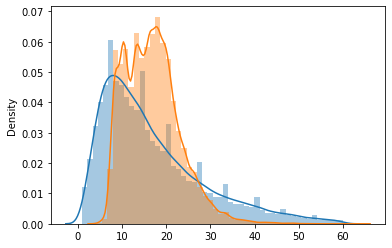

In [63]:
sns.distplot(y_train, label="actual")
sns.distplot(y_pred, label="prediction")